In [15]:
#Fill the paths below
PATH_FRC = "" #git repo directory path
PATH_ZENODO = "" #Data and models are available here: https://zenodo.org/record/5831014#.YdnW_VjMLeo

In [17]:
import sys
import numpy as np
import pandas as pd
import glob
from tqdm import tqdm

import skimage
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.filters import window
import matplotlib
from sklearn import metrics
import tensorflow as tf
from skimage.transform import rescale, resize

sys.path.append(PATH_FRC)
from models2 import FRCUnetModel

matplotlib.rcParams.update({'mathtext.default':'regular'})
matplotlib.rcParams.update({'font.size': 8})
matplotlib.rcParams.update({'axes.labelweight': 'bold'})

In [20]:
def normalise_img(image):
    image = image - image.min()
    image = image/image.max() - 0.5
    return image

def normalise_metrics(data):
    data_norm = data.sub(data.min(axis=1), axis=0)
    data_norm = data_norm.div(data_norm.max(axis=1), axis=0)
    data_norm = data_norm.mean(axis=0)
    return data_norm

def load_model(model_dir, model_fname):
    if model_dir is not None:
        return FRCUnetModel(None, model_path=os.path.join(model_dir, model_fname))

def fourier_ring_correlation_by_ring(image1, image2, rn, spatial_freq):
    # we need the channels first format for this loss
    image1 = tf.transpose(image1, perm=[0, 3, 1, 2])
    image2 = tf.transpose(image2, perm=[0, 3, 1, 2])
    image1 = tf.cast(image1, tf.complex64)
    image2 = tf.cast(image2, tf.complex64)
    rn = tf.cast(rn, tf.complex64)
    fft_image1 = tf.signal.fftshift(tf.signal.fft2d(image1), axes=[2, 3])
    fft_image2 = tf.signal.fftshift(tf.signal.fft2d(image2), axes=[2, 3])

    t1 = tf.multiply(fft_image1, rn)  # (128, BS?, 3, 256, 256)
    t2 = tf.multiply(fft_image2, rn)
    c1 = tf.math.real(tf.reduce_sum(tf.multiply(t1, tf.math.conj(t2)), [2, 3, 4]))
    c2 = tf.reduce_sum(tf.math.abs(t1) ** 2, [2, 3, 4])
    c3 = tf.reduce_sum(tf.math.abs(t2) ** 2, [2, 3, 4])
    frc = tf.math.divide(c1, tf.math.sqrt(tf.math.multiply(c2, c3)))
    frc = tf.where(tf.compat.v1.is_inf(frc), tf.zeros_like(frc), frc)  # inf
    frc = tf.where(tf.compat.v1.is_nan(frc), tf.zeros_like(frc), frc)  # nan
    return frc  

def create_circular_mask(h, w, center=None, radius=None):
    if center is None: # use the middle of the image
        center = [int(w/2), int(h/2)]
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    y, x = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((x - center[0])**2 + (y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

# Load and preprocess data

In [12]:
files = sorted(glob.glob(PATH_ZENODO+"/data/goi_1000/test_50/*"))
clean_images = []

for file in files:
    clean = imread(file)
    if len(clean.shape) > 2:
        clean = np.mean(clean, axis=2)
    minsize = np.array(clean.shape).min()
    clean = clean[:minsize,:minsize]
    clean = tf.convert_to_tensor(clean)
    clean = clean[tf.newaxis, ..., tf.newaxis]
    clean = tf.image.resize(
        clean, [256,256], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR, preserve_aspect_ratio=True, \
        antialias=False, name=None)
    clean = clean.numpy().squeeze()
    clean = normalise_img(clean)
    clean = clean.astype('float32')
    clean = clean*window('hann', clean.shape) 
    clean_images.append(clean)

clean_images = np.stack(clean_images)
clean_images = clean_images[:50,:,:]

# Lowpass images and compute metric values

In [24]:
l2_model=FRCUnetModel(None,None)

In [26]:
lowpass_f = [i for i in range(1,128)]
mses,l1s,frcs = [],[],[]

for i in tqdm(range(50)):

    image=(clean_images[i]-clean_images[i].min()).copy()
    im_fourier = np.fft.fftshift(np.fft.fft2(image))
    mse,l1,frc=[],[],[]
    limages = []
    for f in lowpass_f:
        c = create_circular_mask(256, 256, center=[128,128], radius=f)
        limage = np.fft.ifft2(np.fft.ifftshift(c * im_fourier)).real
        limages.append(limage)
        frc.append(np.sum(fourier_ring_correlation_by_ring(np.reshape(image, [1,256, 256,1]), np.reshape(limage, [1,256, 256,1]), 
                                         l2_model.radial_masks, l2_model.spatial_freq)))
        mse.append(metrics.mean_squared_error(image, limage))
        l1.append(metrics.mean_absolute_error(image, limage))
        
    frcs.append(frc)
    mses.append(mse)
    l1s.append(l1)

100%|██████████| 50/50 [21:58<00:00, 26.37s/it]


In [27]:
mses=pd.DataFrame(mses)
mses=normalise_metrics(mses)

l1s=pd.DataFrame(l1s)
l1s=normalise_metrics(l1s)

frcs=pd.DataFrame(frcs)
frcs=normalise_metrics(frcs)

# Example of a lowpass image

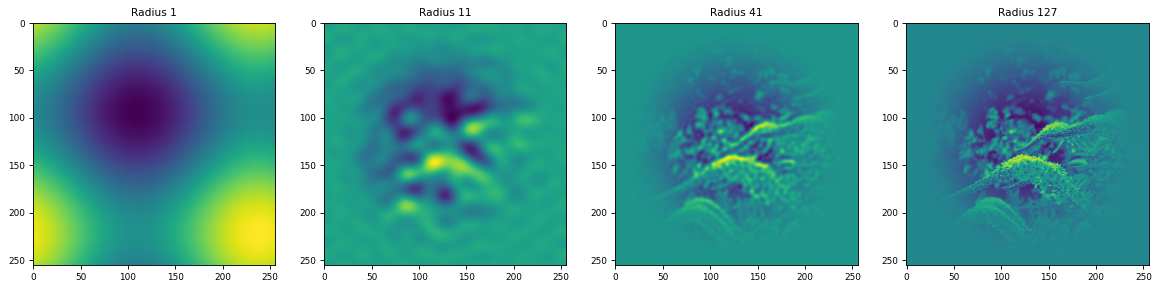

In [28]:
plt.figure(num=None, figsize=(18, 14), dpi=80, facecolor='w', edgecolor='k')

plt.subplot(1,4,1)
plt.title("Radius {}".format(lowpass_f[0]))
plt.imshow(limages[0])

plt.subplot(1,4,2)
plt.title("Radius {}".format(lowpass_f[10]))
plt.imshow(limages[10])

plt.subplot(1,4,3)
plt.title("Radius {}".format(lowpass_f[40]))
plt.imshow(limages[40])

plt.subplot(1,4,4)
plt.title("Radius {}".format(lowpass_f[-1]))
plt.imshow(limages[-1])

# Plot mean dependecies

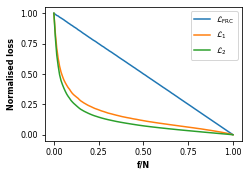

In [29]:
fig = plt.figure()
fig.set_size_inches(3.5, 2.5) 
ax = fig.add_subplot(111)

ax.plot(frcs.index/frcs.index.max(), 1-frcs  , label=r'$\mathcal{L}_{\mathrm{FRC}}$', lw=1.5)
ax.plot(l1s.index/l1s.index.max(), l1s, label=r'$\mathcal{L}_1$', lw=1.5)
ax.plot(mses.index/mses.index.max(), mses, label=r'$\mathcal{L}_2$', lw=1.5)

ax.set_xlabel('f/N')
ax.set_ylabel('Normalised loss')

plt.locator_params(axis='y', nbins=5)
plt.locator_params(axis='x', nbins=5)

ax.legend()
fig.tight_layout()

fig.savefig('figure_3.png', dpi=300)  